In [225]:
import pandas as pd

train = pd.read_csv("./open/train.csv")
test = pd.read_csv("./open/test.csv")

In [226]:
train.head()

,id,temperature,pressure,humidity,wind_speed,wind_direction,precipitation,snowing,cloudiness,target
0,TRAIN_00000,27.8816,1013.6,46.8,2.4,232.4,0.00,False,0.0,1.180
1,TRAIN_00001,5.7540,1026.6,76.6,3.6,172.0,0.00,False,8.8,8.581
2,TRAIN_00002,20.8220,1016.2,64.8,2.2,206.0,0.06,False,23.0,3.978
3,TRAIN_00003,20.0758,1017.4,72.6,0.8,215.4,0.00,False,0.0,8.301
4,TRAIN_00004,7.5260,1023.2,82.8,1.2,158.0,0.00,False,15.0,1.692


In [227]:
test.head()

,id,temperature,pressure,humidity,wind_speed,wind_direction,precipitation,snowing,cloudiness
0,TEST_00000,20.702000,1021.0,76.4,2.0,104.8,0.00,False,23.0
1,TEST_00001,18.673669,1014.4,59.6,2.4,179.2,0.12,False,32.4
2,TEST_00002,29.908000,1020.6,49.6,2.6,78.0,0.60,False,23.0
3,TEST_00003,24.504000,1014.6,61.0,1.8,118.0,0.00,False,15.0
4,TEST_00004,12.590000,1011.4,70.8,1.8,110.0,0.12,False,34.0


In [228]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19275 entries, 0 to 19274
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              19275 non-null  object 
 1   temperature     19275 non-null  float64
 2   pressure        19275 non-null  float64
 3   humidity        19275 non-null  float64
 4   wind_speed      19275 non-null  float64
 5   wind_direction  19275 non-null  float64
 6   precipitation   19275 non-null  float64
 7   snowing         19275 non-null  bool   
 8   cloudiness      19275 non-null  float64
 9   target          19275 non-null  float64
dtypes: bool(1), float64(8), object(1)
memory usage: 1.3+ MB


In [229]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# train['sno'] = pd.Series(le.fit_transform(train['snowing']))
# test['sno'] = pd.Series(le.fit_transform(test['snowing']))

# 1. xgboost 모델링

In [230]:
input_var = ['temperature','pressure','humidity','wind_speed','wind_direction','precipitation','cloudiness', 'snowing']

In [231]:
from xgboost import XGBRegressor

In [232]:
xgb = XGBRegressor(n_estimators=300, learning_rate = 0.1)

In [233]:
xgb.fit(train[input_var], train['target'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [234]:
train['pred'] = xgb.predict(train[input_var])
abs(train['target']-train['pred']).mean()

1.655445777241361

-> 학습시킨 데이터로 예측해본 결과 MAE = 1.655

In [235]:
test['target'] = xgb.predict(test[input_var])
test[['id','target']]
# .to_csv("submission.csv", index = False)

,id,target
0,TEST_00000,4.482109
1,TEST_00001,5.274235
2,TEST_00002,7.311684
3,TEST_00003,4.984435
4,TEST_00004,5.957678
...,...,...
19270,TEST_19270,4.015011
19271,TEST_19271,5.058098
19272,TEST_19272,2.286353
19273,TEST_19273,4.684154


### => 첫번째 제출한 결과 : 2.1138351918

# 2. input변수 개수와 파라미터 조정

In [236]:
# 변수중요도가 큰 순으로 input variables
imt = pd.DataFrame({'var':input_var, 'import':xgb.feature_importances_}).sort_values(by='import',ascending=False)
imt

,var,import
3,wind_speed,0.256770
7,snowing,0.247619
0,temperature,0.089118
5,precipitation,0.088670
1,pressure,0.087158
4,wind_direction,0.079698
2,humidity,0.075513
6,cloudiness,0.075455


In [239]:
import matplotlib.pyplot as plt
%matplotlib inline  # jupyter에서 그래프가 그려지지 않을 때 입력

<function matplotlib.pyplot.show(close=None, block=None)>

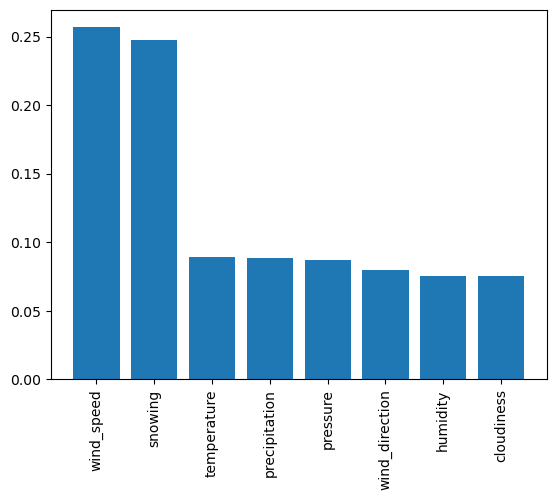

In [240]:
plt.bar(imt['var'], imt['import'])
plt.xticks(rotation=90)
plt.show

-> wind_speed(풍속)과 snowing(눈 오는 상태 여부)가 중요도가 가장 높음

In [241]:
from sklearn.model_selection import cross_val_score

In [242]:
(-1) * cross_val_score(xgb, train[input_var], train['target'], scoring = 'neg_mean_absolute_error', cv = 3).mean()

2.1311058607309987

In [243]:
# input 변수 개수는 몇 개가 좋을 지?
score_list = [] # MAE 점수 리스트
varnum = [] # input variables 개수 리스트

for i in range(1,len(imt)+1):
    select_var = imt['var'].iloc[:i].to_list()
    scores = cross_val_score(xgb, train[select_var], train['target'], scoring = 'neg_mean_absolute_error', cv = 3)
    score_list.append(-scores.mean())
    varnum.append(i)

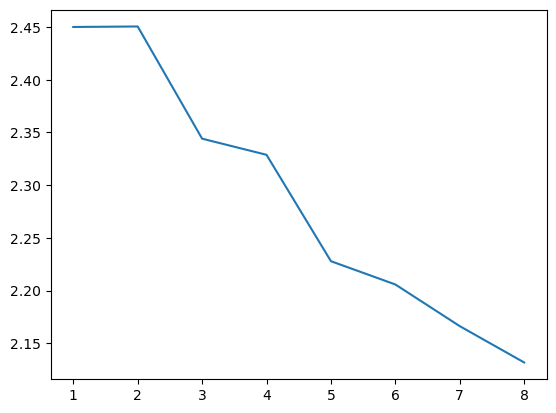

In [244]:
plt.plot(varnum, score_list) 

 -> MAE는 작을수록 좋음 => input변수 8개 다 사용하였을 때 MAE가 가장 낮음

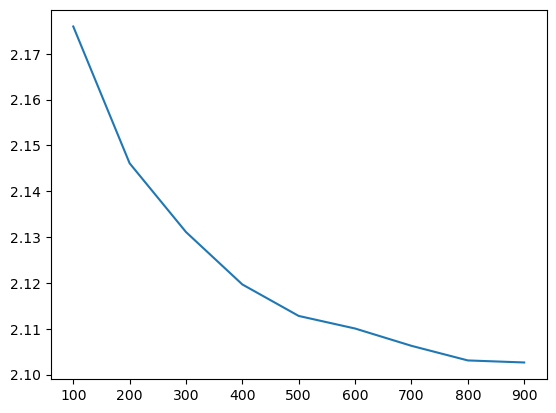

In [245]:
# 파라미터는 몇이 좋을지?
estimators_list = [100,200,300,400,500,600,700,800,900]
score_list = []

for i in estimators_list:
    xgb = XGBRegressor(n_estimators=i, learning_rate=0.1)
    scores = cross_val_score(xgb, train[input_var], train['target'], scoring = 'neg_mean_absolute_error', cv = 3)
    score_list.append(-scores.mean())

plt.plot(estimators_list, score_list)

 -> 파라미터가 커질수록 MAE가 작아짐 => 800부터 기울기가 완만해지므로 800으로 선택

In [247]:
xgb = XGBRegressor(n_estimators=800, learning_rate = 0.1)
xgb.fit(train[input_var],train['target'])
train['pred'] = xgb.predict(train[input_var])
abs(train['target']-train['pred']).mean() # 차이가 300일때보다 더 작아짐 (더 좋아짐)

1.1946983853640012

 -> 파라미터 800으로 변경 후, MAE = 1.195 (더 작아짐, 더 좋아짐!!)

In [75]:
test['target'] = xgb.predict(test[input_var])
test[['id','target']].to_csv("submission.csv", index = False)

### => 두번째 제출한 결과 : 2.0559228502 (첫번째 결과보다 좋아짐)

# 3. 이상치, 결측치 확인

In [250]:
train.info() # 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19275 entries, 0 to 19274
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              19275 non-null  object 
 1   temperature     19275 non-null  float64
 2   pressure        19275 non-null  float64
 3   humidity        19275 non-null  float64
 4   wind_speed      19275 non-null  float64
 5   wind_direction  19275 non-null  float64
 6   precipitation   19275 non-null  float64
 7   snowing         19275 non-null  bool   
 8   cloudiness      19275 non-null  float64
 9   target          19275 non-null  float64
 10  pred            19275 non-null  float32
dtypes: bool(1), float32(1), float64(8), object(1)
memory usage: 1.4+ MB


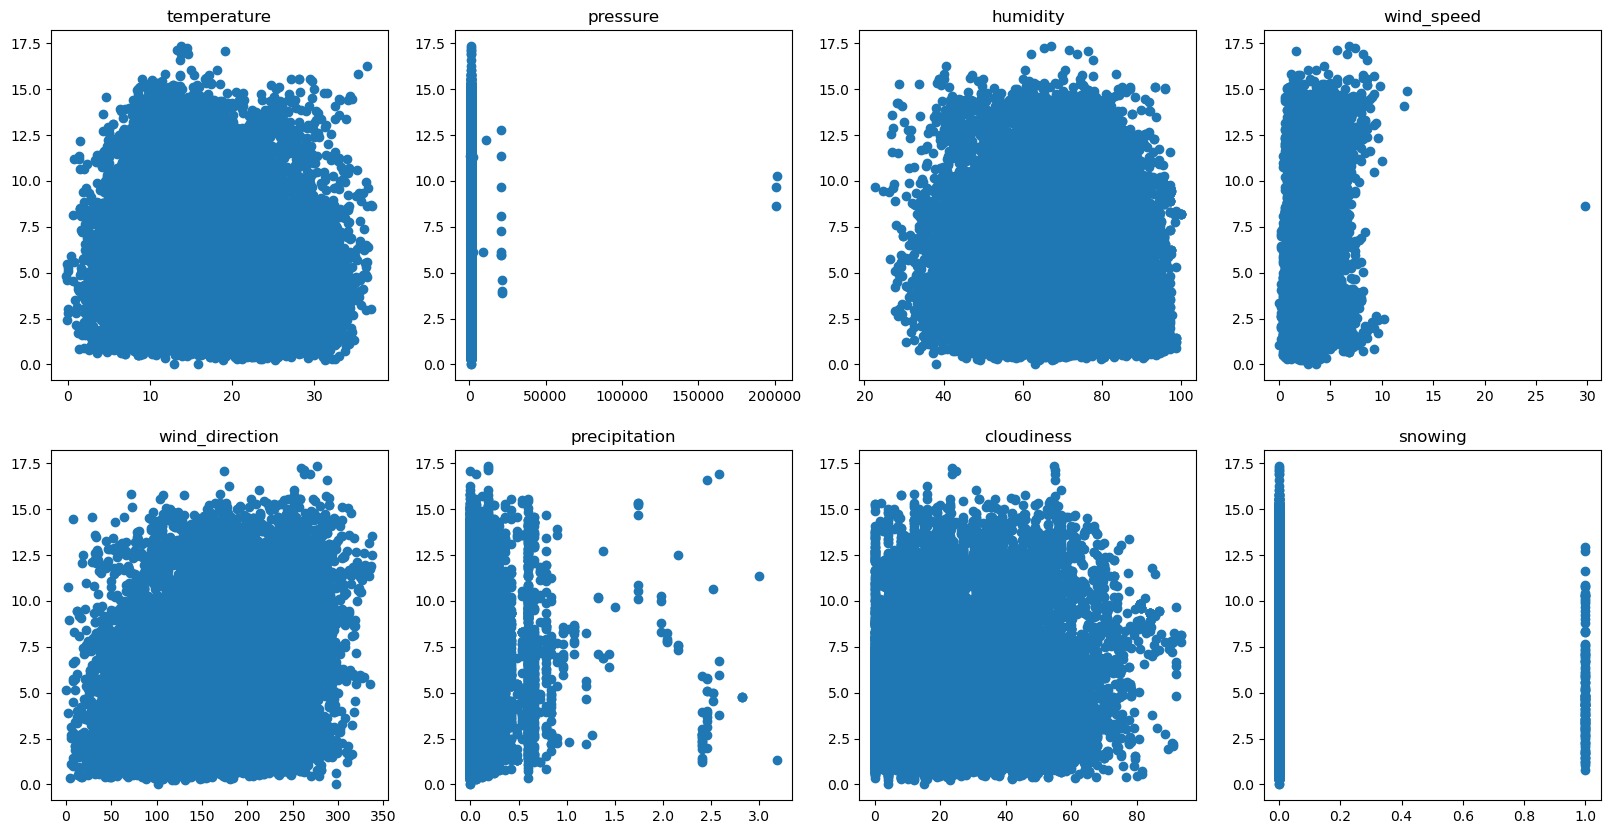

In [121]:
plt.figure(figsize=(20,10))
for i in range(1,len(input_var)+1):
    plt.subplot(2,4,i)
    plt.scatter(train[input_var[i-1]], train['target'])
    plt.title(input_var[i-1])

 -> 다른 관측치에 비해, 기압(pressure)이 높은 관측치 3개와 풍속(wind_speed)이 높은 관측치 1개 발견

In [205]:
# 기압 이상치를 평균으로 대체
t = train[train['pressure']>200000].copy()
t['pressure'] = aa
t

,id,temperature,pressure,humidity,wind_speed,wind_direction,precipitation,snowing,cloudiness,target
495,TRAIN_00495,9.178200,1028.669811,71.4,4.6,278.0,0.24,False,68.8,8.606
12659,TRAIN_12659,9.178863,1028.669811,56.0,2.4,253.8,0.18,False,18.4,10.241
13294,TRAIN_13294,9.384100,1028.669811,71.6,3.8,293.6,0.24,False,68.8,9.683


In [210]:
t = pd.concat([t, train[train['pressure']<200000]])

In [219]:
# 풍속 이상치를 평균으로 대체
tt = t[t['wind_speed']>25].copy()
tt['wind_speed'] = t[t['wind_speed']<25]['wind_speed'].mean()
tt

,id,temperature,pressure,humidity,wind_speed,wind_direction,precipitation,snowing,cloudiness,target
13935,TRAIN_13935,19.572,1000.8,68.6,2.475553,94.0,0.06,False,57.0,8.636


In [221]:
tt = pd.concat([tt, t[t['wind_speed']<25]])
tt

,id,temperature,pressure,humidity,wind_speed,wind_direction,precipitation,snowing,cloudiness,target
13935,TRAIN_13935,19.572000,1000.800000,68.6,2.475553,94.0,0.06,False,57.0,8.636
495,TRAIN_00495,9.178200,1028.669811,71.4,4.600000,278.0,0.24,False,68.8,8.606
12659,TRAIN_12659,9.178863,1028.669811,56.0,2.400000,253.8,0.18,False,18.4,10.241
13294,TRAIN_13294,9.384100,1028.669811,71.6,3.800000,293.6,0.24,False,68.8,9.683
0,TRAIN_00000,27.881600,1013.600000,46.8,2.400000,232.4,0.00,False,0.0,1.180
...,...,...,...,...,...,...,...,...,...,...
19270,TRAIN_19270,12.020000,1023.800000,81.4,1.600000,176.0,0.00,False,0.0,7.047
19271,TRAIN_19271,17.232000,993.200000,78.2,2.000000,198.0,0.06,False,26.4,3.670
19272,TRAIN_19272,13.748000,999.800000,65.0,6.400000,260.0,0.36,False,53.0,3.328
19273,TRAIN_19273,19.354000,1019.400000,45.4,2.400000,120.0,0.06,False,20.0,12.379


In [222]:
xgb = XGBRegressor(n_estimators=800, learning_rate=0.1)
xgb.fit(tt[input_var], tt['target'])
tt['pred'] = xgb.predict(tt[input_var])
abs(tt['target']-tt['pred']).mean()

1.1916722645152382

 -> 이상치를 평균으로 대체 후, MAE = 1.192 (더 작아짐, 더 좋아짐)

In [223]:
test['target'] = xgb.predict(test[input_var])
test[['id','target']].to_csv("submission.csv", index = False) # 저장만 하고 제출 아직임!!